# Unidad Práctica 5 (preliminar): Introducción a la Visualización de Redes

Por **Eduardo Graells-Garrido**. <egraells@udd.cl>. 

Actualizado: **2 de octubre de 2021**.

En este notebook exploraremos los viajes de la Encuesta Origen-Destino 2012 de Santiago utilizando visualizaciones de redes.


## Google Colab

Para ejecutar este notebook en Colab, primero ejecuten la siguiente celda. Luego el notebook se reiniciará.

In [ ]:
!pip uninstall matplotlib -y
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

Una vez que se ha reiniciado puedes ejecutar el resto de las celdas.

In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git
!mamba env update --name base --file aves_git/environment-colab.yml

## Preámbulo y Carga de Datos

In [1]:
import sys
from pathlib import Path

AVES_ROOT = Path("..") if not "google.colab" in sys.modules else Path("aves_git")

EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('../data/external/EOD_STGO')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

from aves.data import eod, census
from aves.features.utils import normalize_rows

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 192
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [3]:
comunas = census.read_census_map('comuna', path=AVES_ROOT / "data" / "external" / "censo_2017_R13")

In [4]:
zones = gpd.read_file(AVES_ROOT / 'data' / 'processed' / 'scl_zonas_urbanas.json').set_index('ID')
zones.head()

,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,area_m2,geometry
ID,,,,,,,,,,,,,,,,
103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,4.575649e+05,"POLYGON ((-70.65492 -33.55500, -70.65517 -33.5..."
104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.725462e+05,"POLYGON ((-70.67599 -33.55542, -70.67452 -33.5..."
106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,2.693838e+06,"POLYGON ((-70.69714 -33.56361, -70.69714 -33.5..."
115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.534193e+05,"POLYGON ((-70.67625 -33.55513, -70.67653 -33.5..."
116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.184305e+05,"POLYGON ((-70.66564 -33.55260, -70.66309 -33.5..."


In [5]:
viajes = eod.read_trips(EOD_PATH)

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[
    (viajes["SectorOrigen"] != "Exterior a RM")
    & (viajes["SectorDestino"] != "Exterior a RM")
    & (viajes["SectorOrigen"] != "Extensión Sur-Poniente")
    & (viajes["SectorDestino"] != "Extensión Sur-Poniente")
    & pd.notnull(viajes["SectorOrigen"])
    & pd.notnull(viajes["SectorDestino"])
]

print(len(viajes))


89541


In [6]:
personas = eod.read_people(EOD_PATH)
viajes_persona = viajes.merge(personas)

In [7]:
viajes_persona["PesoLaboral"] = (
    viajes_persona["FactorLaboralNormal"] * viajes_persona["Factor_LaboralNormal"]
)


## ¿Cómo se relacionan las comunas de acuerdo a los viajes entre ellas, por propósito?

Primero, preparemos el `GeoDataFrame` de comunas. Tenemos que quedarnos solo con las comunas que nos interesan, y tenemos que asegurarnos que tenga los mismos nombres que en el `DataFrame` de viajes.

In [8]:
comunas.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,1.625330,0.066035,"POLYGON ((-70.61889 -33.73808, -70.61811 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,"POLYGON ((-70.63192 -33.64634, -70.63207 -33.6..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78914 -33.36153, -70.78824 -33.3..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13103,CERRO NAVIA,0.170180,0.001076,"POLYGON ((-70.71927 -33.41334, -70.71888 -33.4..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,133,CHACABUCO,13301,COLINA,1.692007,0.093820,"POLYGON ((-70.59630 -32.95138, -70.59673 -32.9..."


Hacemos dos cosas:

- Como tenemos las zonas urbanas, filtramos el `GeoDataFrame` para quedarnos solamente con aquellas comunas que están en el `DataFrame` de zonas.
- Hacemos un diccionario de `código de comuna -> nombre de comuna` a partir de las zonas y lo aplicamos.

<AxesSubplot:>

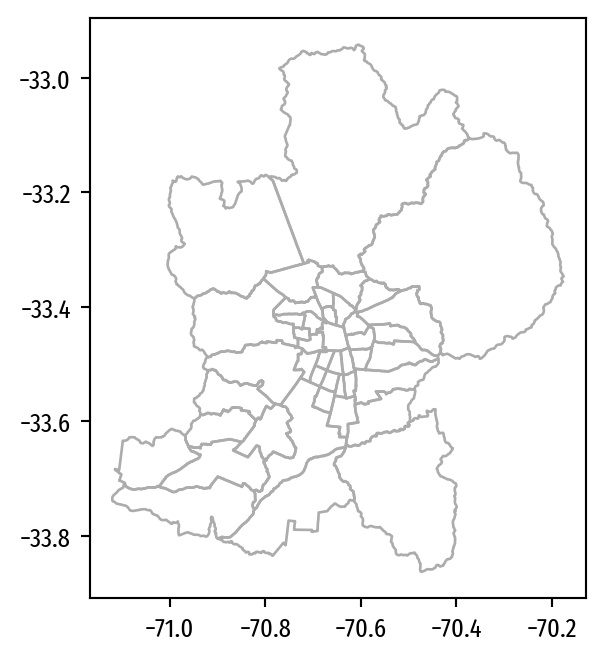

In [9]:
comunas_urbanas = comunas[comunas['COMUNA'].isin(zones['Com'].unique())].drop('NOM_COMUNA', axis=1).copy()
comunas_urbanas['NombreComuna'] = comunas_urbanas['COMUNA'].map(dict(zip(zones['Com'], zones['Comuna'])))
comunas_urbanas.plot(facecolor="none", edgecolor="#abacab")

El mapa es demasiado grande, así que lo recortaremos utilizando las zonas que conocemos:

In [10]:
from aves.features.geo import clip_area_geodataframe

In [11]:
bounding_box = zones.total_bounds
bounding_box

array([-70.995712  , -33.76479118, -70.44502298, -33.17216184])

In [12]:
comunas_urbanas = clip_area_geodataframe(comunas_urbanas, zones.total_bounds, buffer=0.05)

Calculamos la lista de aristas de nuestra red, es decir, la cantidad de viajes de una comuna a otra. En este caso, lo haremos con los viajes al trabajo.

In [13]:
matriz = (
    viajes_persona[
        (viajes_persona["Proposito"] == "Al trabajo")
        & (viajes_persona["ComunaOrigen"].isin(comunas_urbanas["NombreComuna"]))
        & (viajes_persona["ComunaDestino"].isin(comunas_urbanas["NombreComuna"]))
    ]
    .groupby(["ComunaOrigen", "ComunaDestino"])
    .agg(n_viajes=("PesoLaboral", "sum"))
    .reset_index()
)

matriz.head()


,ComunaOrigen,ComunaDestino,n_viajes
0,Calera de Tango,Calera de Tango,2400.450674
1,Calera de Tango,Cerrillos,47.478444
2,Calera de Tango,Colina,0.000000
3,Calera de Tango,Estación Central,0.000000
4,Calera de Tango,La Cisterna,222.818975


Podemos convertir esta lista en una matriz de adyacencia. Veamos como luce esta matriz con el esquema `adjacency_matrix`. Como vimos en clase, utiliza la misma codificación visual que el `heatmap` de tablas, por lo que podemos usar `seaborn.heatmap` para visualizarla:

<AxesSubplot:xlabel='ComunaDestino', ylabel='ComunaOrigen'>

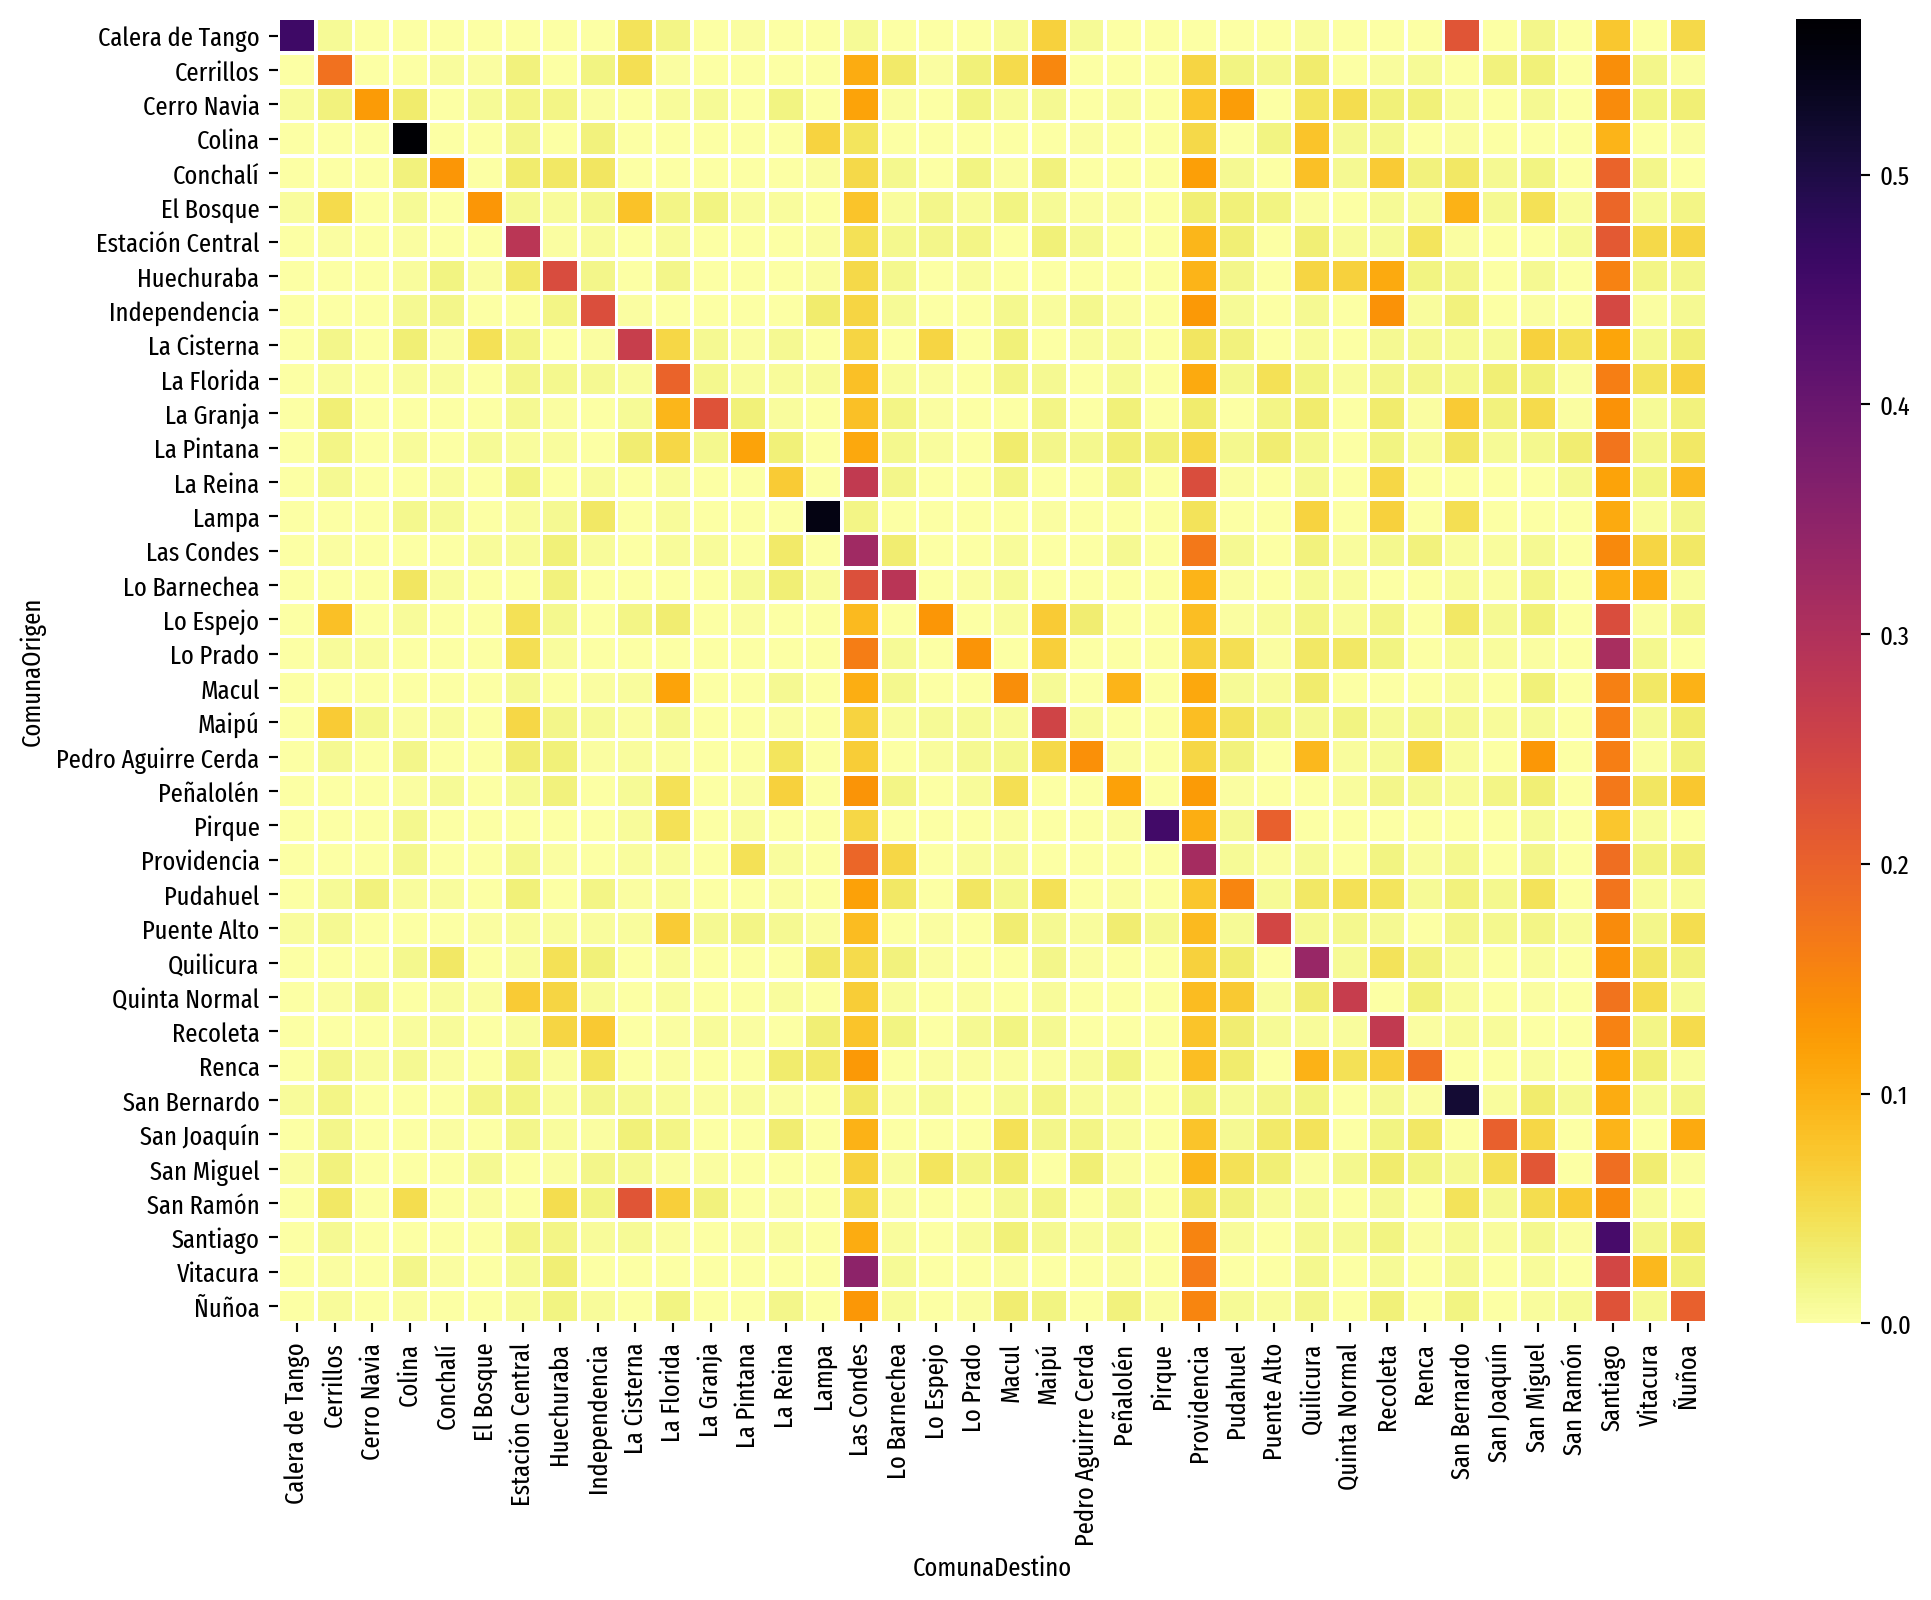

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    matriz.set_index(["ComunaOrigen", "ComunaDestino"])["n_viajes"]
    .unstack(fill_value=0)
    .pipe(normalize_rows),
    cmap="inferno_r",
    linewidth=1,
)


También podemos utilizar el dataframe `matriz` como una lista de aristas que podemos visualizar con un gráfico NodeLink. A diferencia de la clase pasada, donde debíamos calcular la posición de cada nodo, al utilizar información geográfica los nodos ya tienen una posición.

In [15]:
from aves.models.network import Network

od_network = Network.from_edgelist(
    # graficamos los viajes más representativos
    matriz[matriz["n_viajes"] > matriz["n_viajes"].quantile(0.75)],
    source="ComunaOrigen",
    target="ComunaDestino",
    weight="n_viajes",
)


In [16]:
from aves.visualization.networks import NodeLink

nodelink = NodeLink(od_network)
nodelink.layout_nodes(method='geographical', geodataframe=comunas_urbanas, node_column='NombreComuna')

/home/egraells/resources/aves/notebooks/aves/models/network/layouts.py:165: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_positions = positions_to_array(self.geodf.geometry.centroid)


En esta ocasión tenemos una red dirigida. Sabemos que los viajes van desde una comuna de origen hasta una comuna de destino. Por tanto, necesitamos una manera de identificar la dirección de las aristas. Una manera de hacerlo es pintarlas con un gradiente de color donde el azul representa el origen y el rojo representa el destino:

In [17]:
nodelink.set_edge_drawing('origin-destination')

In [18]:
nodelink.set_node_drawing("plain", weights=od_network.node_degree("in"))


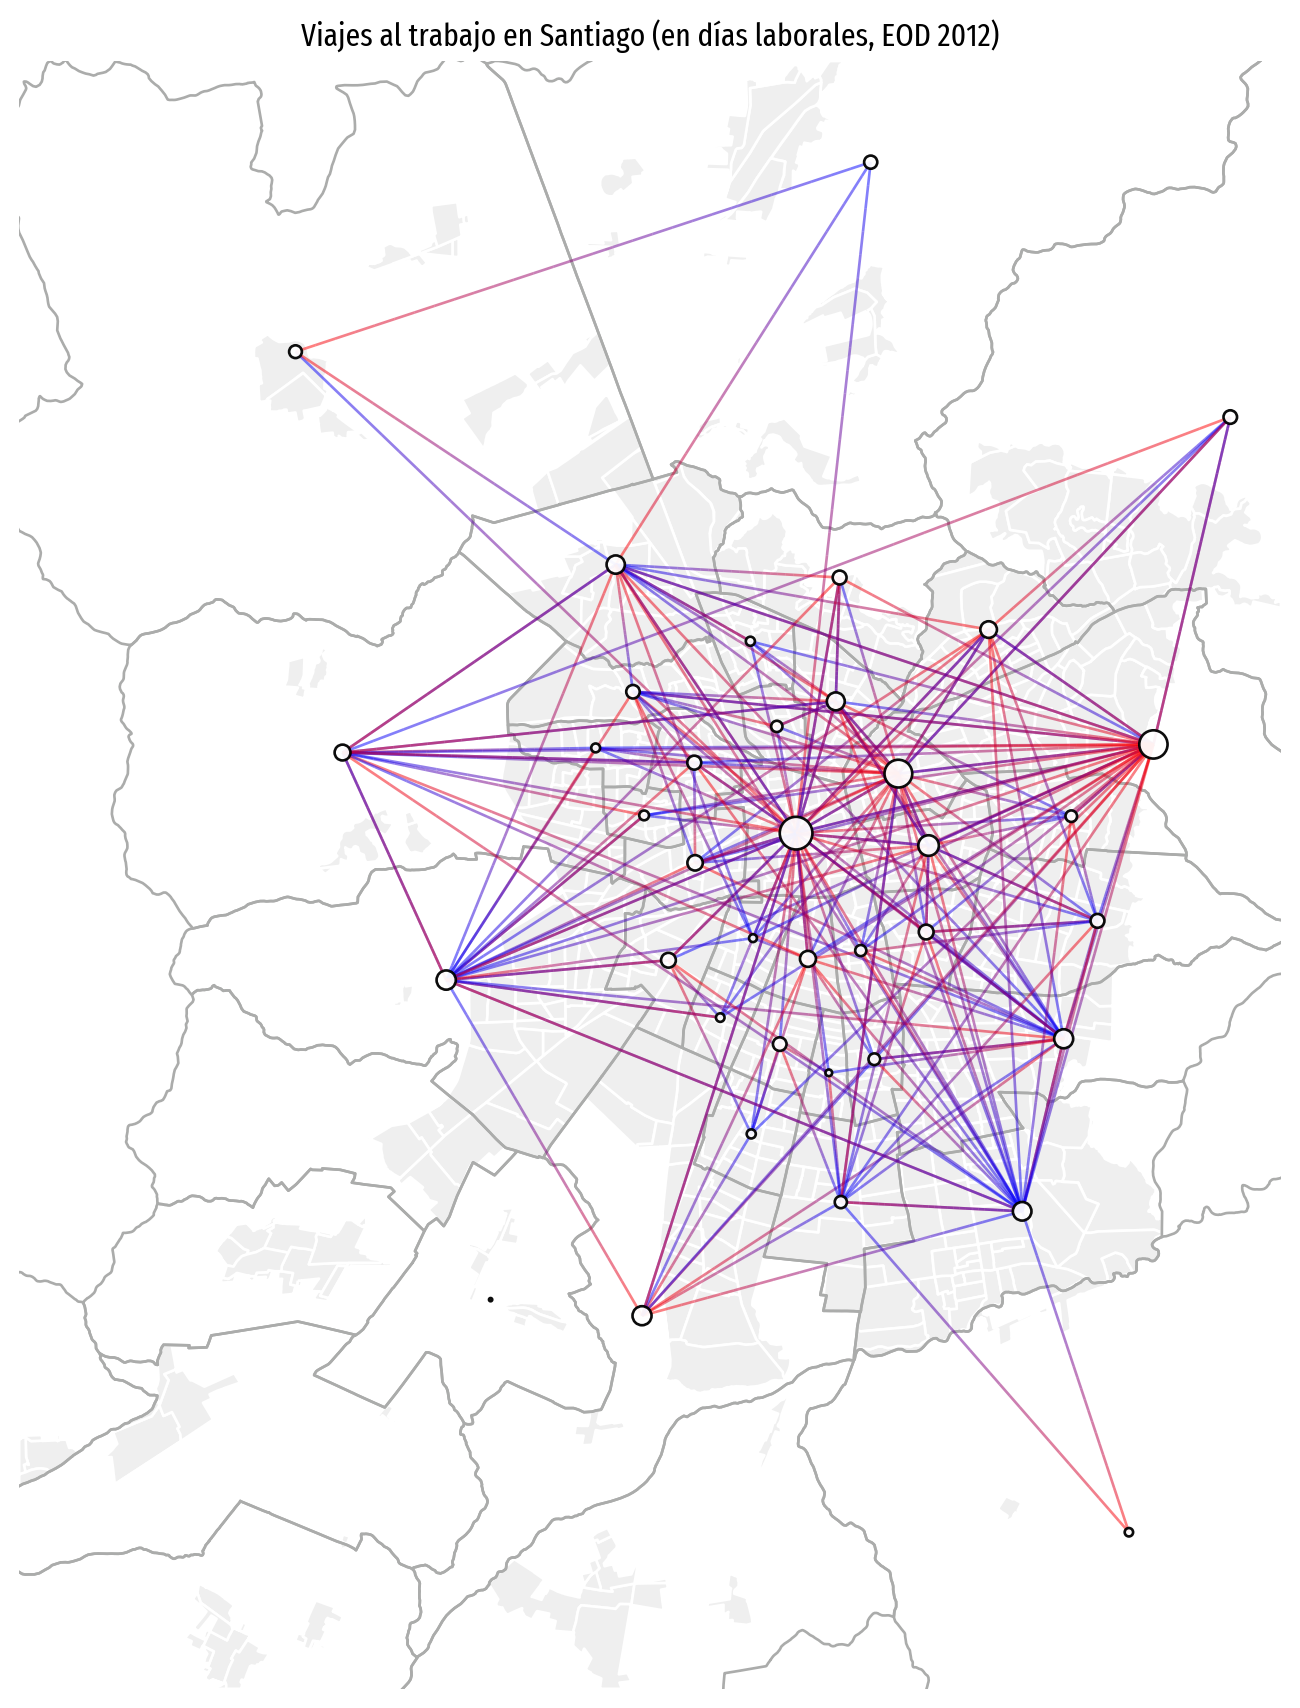

In [19]:
from aves.visualization.figures import figure_from_geodataframe

fig, ax = figure_from_geodataframe(zones, height=9)

# contexto
zones.plot(ax=ax, facecolor='#efefef', edgecolor='white', zorder=0)
comunas_urbanas.plot(ax=ax, facecolor='none', edgecolor='#abacab', zorder=1)

nodelink.plot(ax, nodes=dict(color='white', edgecolor='black', node_size=150, alpha=0.95), edges=dict(alpha=0.5), zorder=2)

ax.set_title('Viajes al trabajo en Santiago (en días laborales, EOD 2012)')

fig.tight_layout()

En comparación con la matriz de adyacencia, en esta visualización además de identificar las relaciones entre comunas podemos apreciar el contexto geográfico. Antes de elegir una de estas dos visualizaciones, debemos considerar lo siguiente:

- ¿Nos interesa conocer la relación geográfica entre orígenes y destinos? Por ej., ¿queremos saber si comunas vecinas se comportan similar?¿Nos interesa la distancia de los viajes? En este caso, `node_link` es una buena solución.
- ¿Necesitamos ver _todas_ las aristas? Si es así, el gráfico de `node_link` podría ser inadecuado, ya que no podemos cambiar la posición de los nodos, ni podemos ver las aristas en las que el origen y destino son iguales. Debemos usar `adjacency_matrix`.

**Ejercicio Propuesto**: realizar el mismo análisis para distintos propósitos de viaje. Realizarlo a nivel de zonas (ver README de aves para un ejemplo con zonas).